# Wrangle and Analyze Data

## Contents
- [Gather Data](#Gather-Data)
    - [Gather the archive data](#Gather-the-archive-data)
    - [Gather the image prediction data](#Gather-the-image-prediction-data)
    - [Gather the tweet json data](#Gather-the-tweet-json-data)
- [Assess Data](#Assess-Data)
    - [Assess the archive data](#Assess-the-archive-data)
    - [Assess the image prediction data](#Assess-the-image-prediction-data)
    - [Assess the tweet json data](#Assess-the-tweet-json-data)
- [Some Problems](#Some-Problems)
- [Clean Data](#Clean-Data)

## Gather Data

In [1]:
# Import libs
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import time
import datetime as dt
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

### Gather the archive data

In [2]:
# Load the WeRateDog archive data (CSV)
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

### Gather the image prediction data

In [3]:
# Request url
image_pred_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
# Request the image prediction data from the internet
response = requests.get(image_pred_url)
image_pred_file_name = "image-predictions.tsv"
# Write to file from the response content
with open(image_pred_file_name, mode='wb') as file:
    file.write(response.content)    

In [4]:
# Load the saved file to dataframe
image_pred_file_name = "image-predictions.tsv"
image_pred = pd.read_csv(image_pred_file_name, sep='\t')

### Gather the tweet json data

In [5]:
# Get twitter API keys, saved in the tweet_key.json
# Keys should include: 'consumer_key', 'consumer_secret', 'access_token', 'access_token_secret'
with open('other/tweet_key.json') as keyfile:
    tweet_key = json.load(keyfile)
print(tweet_key.keys())

dict_keys(['consumer_key', 'consumer_secret', 'access_token', 'access_token_secret'])


In [6]:
# Initialize Tweepy API
auth = tweepy.OAuthHandler(tweet_key['consumer_key'], tweet_key['consumer_secret'])
auth.set_access_token(tweet_key['access_token'], tweet_key['access_token_secret'])
# Set the rate_limit related params
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
# Test the api call with tweepy
test = api.get_status(886054160059072513) # tweet_id = 888202515573088257
print(test._json)

{'created_at': 'Sat Jul 15 02:45:48 +0000 2017', 'id': 886054160059072513, 'id_str': '886054160059072513', 'text': 'RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo', 'truncated': False, 'entities': {'hashtags': [{'text': 'BATP', 'indices': [21, 26]}], 'symbols': [], 'user_mentions': [{'screen_name': 'Athletics', 'name': 'Oakland Athletics 🌳🐘⚾️', 'id': 19607400, 'id_str': '19607400', 'indices': [3, 13]}], 'urls': [{'url': 'https://t.co/WxwJmvjfxo', 'expanded_url': 'https://twitter.com/dog_rates/status/886053434075471873', 'display_url': 'twitter.com/dog_rates/stat…', 'indices': [27, 50]}]}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™', 'screen_name': 'dog_rates', 'location': '⇩ merch ⇩         DM YOUR DO

In [8]:
# Display the included tweet data
print(test._json.keys())

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])


**Get Json data by tweepy API call**  
1. Define lists to stored queried tweet_id. One list store the successfully queried tweet_id, Another list store the failed queried tweet_id. Store the two lists in the IPython database.
2. Define a function to extract data by tweet_id in the twitter_archive dataframe through tweepy API and store data in the tweet_json.txt. 
3. After the first run of the function above, skip excuting again by adding `if 1==0:` at the begining.

In [9]:
# Define a list to store the tweet_id when queried successfully
queried_tweet_ids=[]
# Define a list to store the tweet_id when query encounters exception
exception_tweet_ids=[]

In [10]:
# Extract all tweet's data based on the tweet_id in the twet_arch, and store in json file: tweet_json.txt
# Define a function to get data
def extractData():
    # Define timer to get the consuming time of the tweepy API request
    # Time begin
    start = time.time()
    # Open file as write and append mode
    with open('tweet_json.txt', mode='w+') as tweet_json:
        # Loop the tweet_id and query the data
        for tid in twitter_archive['tweet_id']:
            try:
                # API call to get tweet data
                data = api.get_status(tid)
                # add the newline character for each request
                tweet_json.write(json.dumps(data._json)+'\n')
                # Add the tweet_id which can get data successfully 
                queried_tweet_ids.append(tid)
            except tweepy.RateLimitError as re:
                exception_tweet_ids.append(tid)
                print(e)
                continue
            except tweepy.TweepError as e:
                exception_tweet_ids.append(tid)
                print(e)
                continue
    # Time end
    end = time.time()
    # The consuming time
    print(end - start)   

In [11]:
# As the time and resource comsuming of getting data, skip this cell execution after getting the json data on the first time
# Remove the if 1==0: to resume
if 1==0:
    extractData();
    # Store the lists
    %store queried_tweet_ids
    %store exception_tweet_ids 
# Print the tweet_id which have no status info
# There are no values in the exception_tweet_ids and queried_tweet_ids lists,
# as the store functions are updated features after the initial run
exception_tweet_ids    

[]

In [12]:
# Read data from the saved json file
tweet_json = pd.read_json('tweet_json.txt',lines=True)

## Assess Data

### Assess the archive data

In [13]:
# Assess the WeRateDogs archive data
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [14]:
# Check the original data info
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
# Show all doggo values
twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [16]:
# Show all floofer values
twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [17]:
# Show all pupper values
twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [18]:
# Show all puppo values
twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [19]:
# Show all retweeted_status_user_id that is not NaN 
twitter_archive[twitter_archive['retweeted_status_user_id'].isna()==False].retweeted_status_user_id.astype(np.int64).value_counts()

4196983835            156
4296831739              2
41198418                1
66699013                1
712457247234756608      1
1228325660              1
280479778               1
154767397               1
787461778435289088      1
487197737               1
24885566                1
363890752               1
747554344434831360      1
79923701                1
19607400                1
44667502                1
783214                  1
811740824               1
512804507               1
195036846               1
597064155               1
341021133               1
58709723                1
726634734               1
1732729088              1
Name: retweeted_status_user_id, dtype: int64

In [20]:
# Show all in_reply_to_user_id that is not NaN 
twitter_archive[twitter_archive['in_reply_to_user_id'].isna()==False].in_reply_to_user_id.astype(np.int64).value_counts()

4196983835            47
21955058               2
26259576               1
30582082               1
21435658               1
113211856              1
16374678               1
194351775              1
2281181600             1
467036706              1
77596200               1
1582853809             1
840547864354918400     1
730505014150582272     1
15846407               1
291859009              1
4717297476             1
180670967              1
20683724               1
28785486               1
16487760               1
11856342               1
1198988510             1
279280991              1
358972768              1
29166305               1
2319108198             1
3105440746             1
2894131180             1
47384430               1
13615722               1
Name: in_reply_to_user_id, dtype: int64

From above, the user id of 4196983835 has the largest reply and retweet records. **Guess**, the 4196983835 is the user id of *@dog_rates*

In [21]:
# Get the user info of the user "@dog_rates", the screen name
dog_rates = api.get_user('dog_rates')
print(dog_rates._json)

{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™', 'screen_name': 'dog_rates', 'location': '⇩ merch ⇩         DM YOUR DOGS', 'profile_location': None, 'description': 'Your Only Source For Professional Dog Ratings ⠀ ⠀IG, FB, Snapchat ⇨ WeRateDogs ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ Business: dogratingtwitter@gmail.com', 'url': 'https://t.co/N7sNNHAEXS', 'entities': {'url': {'urls': [{'url': 'https://t.co/N7sNNHAEXS', 'expanded_url': 'http://weratedogs.com', 'display_url': 'weratedogs.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 7430642, 'friends_count': 10, 'listed_count': 5509, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'favourites_count': 139525, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 9164, 'lang': 'en', 'status': {'created_at': 'Fri Nov 16 01:31:06 +0000 2018', 'id': 1063243027186102272, 'id_str': '1063243027186102272', 'text': '@Chilequiles88 i gotchu bb https://t.co/ACnrgWp7qK

In [22]:
# Show all rating numerator values
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [23]:
# Show all rating denominator values
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [24]:
# Show the records of which the rating_denominator and rating_numerator are not make sense in terms of the rating system.
twitter_archive.query('rating_denominator!=10 | rating_numerator>20')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None


In [25]:
# Check values of the source columns
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [26]:
# Get all retweet id from retweeted_status_id
retweeted_status_id_list = twitter_archive[twitter_archive.retweeted_status_id.isnull()==False].retweeted_status_id.astype(np.int64)

In [27]:
# Check if the 'tweet_id' includes retweet data
twitter_archive[twitter_archive.tweet_id.isin(retweeted_status_id_list)].count()[0]

112

In [28]:
# Get all reply id from reply_status_id
reply_status_id_list = twitter_archive[twitter_archive.in_reply_to_status_id.isnull()==False].in_reply_to_status_id.astype(np.int64)

In [29]:
# Check if the 'tweet_id' includes 'reply-to' tweet data
twitter_archive[twitter_archive['tweet_id'].isin(reply_status_id_list)].count()[0]

33

In [30]:
twitter_archive.timestamp.sample(10)

52      2017-07-04 01:18:17 +0000
378     2017-02-04 17:34:40 +0000
392     2017-01-30 17:10:04 +0000
474     2017-01-03 01:20:49 +0000
1791    2015-12-17 03:53:20 +0000
291     2017-03-04 17:56:49 +0000
1615    2016-01-08 01:16:17 +0000
1467    2016-02-02 01:21:07 +0000
1354    2016-02-27 17:24:05 +0000
1657    2016-01-02 04:27:31 +0000
Name: timestamp, dtype: object

### Assess the image prediction data

In [31]:
# Assess the image prediction data
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [32]:
# Check the image prediction data
image_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [33]:
# Show the p1's value list
image_pred.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     20
web_site                      19
Cardigan                      19
Eskimo_dog                    18
Maltese_dog                   18
Shetland_sheepdog             18
beagle                        18
teddy                         18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
Italian_greyhound             16
kuvasz                        16
          

In [34]:
# Show the image count
image_pred.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [35]:
# Show the image urls for those tweet that have multiple images
image_pred[image_pred.img_num>1].jpg_url

144     https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg
312     https://pbs.twimg.com/media/CVHRIiqWEAAj98K.jpg
315     https://pbs.twimg.com/media/CVJ79MzW4AEpTom.jpg
319     https://pbs.twimg.com/media/CVKZsHtWwAA6gPj.jpg
345     https://pbs.twimg.com/media/CVRkLuJWUAAhhYp.jpg
381     https://pbs.twimg.com/media/CVgbIobUYAEaeI3.jpg
382     https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg
410     https://pbs.twimg.com/media/CVoha_IU4AAZ7vi.jpg
441     https://pbs.twimg.com/media/CVwx3dQXAAA0ksL.jpg
452     https://pbs.twimg.com/media/CV0zkzEU4AAzLc5.jpg
454     https://pbs.twimg.com/media/CV0_BSuWIAIvE9k.jpg
478     https://pbs.twimg.com/media/CV9EvZNUwAAgLCK.jpg
479     https://pbs.twimg.com/media/CV9SrABU4AQI46z.jpg
494     https://pbs.twimg.com/media/CWCbd8ZWoAAtqoH.jpg
511     https://pbs.twimg.com/media/CWJQ4UmWoAIJ29t.jpg
517     https://pbs.twimg.com/media/CWMyl9EWUAAnZJ0.jpg
530     https://pbs.twimg.com/media/CWSL4W8WsAAE4KU.jpg
531     https://pbs.twimg.com/media/CWSN-vaXAAA8

In [36]:
# Check if exist duplicated data
image_pred[image_pred.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Assess the tweet json data

In [37]:
# Show tweet_json info
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 30 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2342 non-null datetime64[ns]
entities                         2342 non-null object
extended_entities                1823 non-null object
favorite_count                   2342 non-null int64
favorited                        2342 non-null bool
geo                              0 non-null float64
id                               2342 non-null int64
id_str                           2342 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  2342 non-null bool
lang                             2342 no

In [38]:
# Show all values of source
tweet_json.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2207
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [39]:
# Show all values of language
tweet_json.lang.value_counts()

en     2324
und       7
nl        3
in        3
et        1
ro        1
eu        1
es        1
tl        1
Name: lang, dtype: int64

In [40]:
# Show properties of 'user' object 
tweet_json.iloc[0,].user.keys()

dict_keys(['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url', 'entities', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'utc_offset', 'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'is_translator', 'is_translation_enabled', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_image_url', 'profile_image_url_https', 'profile_banner_url', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'following', 'follow_request_sent', 'notifications', 'translator_type'])

In [41]:
# Show properties of 'entities' object 
tweet_json.iloc[0,].entities.keys()

dict_keys(['hashtags', 'symbols', 'user_mentions', 'urls', 'media'])

In [42]:
# Show all values of 'created' column
tweet_json.created_at.sort_values(ascending=True)

2341   2015-11-15 22:32:08
2340   2015-11-15 23:05:30
2339   2015-11-15 23:21:54
2338   2015-11-16 00:04:52
2337   2015-11-16 00:24:50
2336   2015-11-16 00:30:50
2335   2015-11-16 00:35:11
2334   2015-11-16 00:49:46
2333   2015-11-16 00:55:59
2332   2015-11-16 01:01:59
2331   2015-11-16 01:22:45
2330   2015-11-16 01:52:02
2329   2015-11-16 01:59:36
2328   2015-11-16 02:38:37
2327   2015-11-16 03:22:39
2326   2015-11-16 03:44:34
2325   2015-11-16 03:55:04
2324   2015-11-16 04:02:55
2323   2015-11-16 14:57:41
2322   2015-11-16 15:14:19
2321   2015-11-16 16:11:11
2320   2015-11-16 16:37:02
2319   2015-11-16 19:31:45
2318   2015-11-16 20:01:42
2317   2015-11-16 20:32:58
2316   2015-11-16 21:10:36
2315   2015-11-16 21:54:18
2314   2015-11-16 23:23:41
2313   2015-11-17 00:06:54
2312   2015-11-17 00:24:19
               ...        
29     2017-07-15 16:51:35
28     2017-07-15 23:25:31
27     2017-07-16 20:14:00
26     2017-07-16 23:58:41
25     2017-07-17 16:17:36
24     2017-07-18 00:07:08
2

In [43]:
# Get other interested information (favorite_count, retweet_count) and define as tweet_other_info
tweet_other_info = tweet_json[['id','favorite_count','retweet_count']]

In [44]:
tweet_other_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
id                2342 non-null int64
favorite_count    2342 non-null int64
retweet_count     2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


### Some Problems
#### twitter_archive
- Tidiness
    - The category of dog 'stage' is separated to four columns: doggo, floofer, pupper and puppo.
    - One tweet may have multiple dog stages as multiple dog pictures may be included. This stage information is dog's property and has a one-to-many relationship with tweet. 
    - One tweet can contain multiple expanded_url values and new dataset should be created to store the one-to-many relationship.

- Quality
    - The tweet_id column is int64 type, but string type is better for id field.
    - The in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id columns are float types.
    - The timestamp, retweeted_status_timestamp columns are string types.
    - The 'source' column includes the http tag information(`<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>`).
    - The 'tweet_id' includes retweet information.
    - The 'tweet_id' includes reply information.
    - Missing values on expanded_urls column. And multiple duplicted values like `https://twitter.com/dog_rates/status/782305867769217024/photo/1,`
`https://twitter.com/dog_rates/status/782305867769217024/photo/1,`
`https://twitter.com/dog_rates/status/782305867769217024/photo/1`.
> This column is confusing as the 'expanded_url' could be from three places: in entities.urls, entities.media and extended_entities.media. 
> After checking [Twitter API Doc](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#entitiesobject):
    > - **entities.urls**: Represents URLs included in the text of a Tweet.  
    > - **entities.media:** The entities section will contain a media array containing a single media object if any media object has been ‘attached’ to the Tweet. Even though up to four photos can be attached, only the first one will be listed in the entities section.  
    > - **extended_entities.media:** All Tweets with attached photos, videos and animated GIFs will include an extended_entities JSON object. The extended_entities object contains a single media array of media objects.   
> By assessing the data and the API doc and example, there is a better understanding of the values in expanded_urls: the column includes the 'expanded_url' of all the above sources. If one tweet that has native media(e.g. four photos) and two referenced urls, the 'expanded_urls' will contain five duplicated expanded_url values(one from the *entities.media*, four from the *extended_entities.media*) about the photos and two different expanded_url values about the referenced urls.


#### tweet_other_info
- Tidiness
    - This dataframe should be part of twitter_archive information.
- Quality
    - The id column is int type.
    
#### image_pred
- Quality
    - The prediction of dog breed names are not well formated (golden_retriever, Labrador_retriever, vizsla etc.)
    - The tweet_id column is int type.

## Clean Data

In [45]:
# Make copy of the original data
twitter_archive_clean = twitter_archive.copy()
image_pred_clean = image_pred.copy()
tweet_other_info_clean = tweet_other_info.copy()
# Load the initially saved json data
tweet_json = pd.read_json('tweet_json.txt',lines=True)
tweet_json_clean = tweet_json.copy()
# Conect the sqlite database
db_conn = sqlite3.connect('dog_rates.db')

### Define Issue
The tweet_id column is int64 type, should convert to string type.

Clean Steps:
1. Convert the tweet_id from int64 type to string

### Code

In [46]:
# Convert each value to string type
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.apply(str)

### Test

In [47]:
# Check info
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

### Define Issue
The category of dog 'satge' are separated to four columns: doggo, floofer, pupper and puppo. They should be in one categorical column.

Clean Steps:
1. Use melt function to reshape the dataframe to merge doggo, floofer, pupper and puppo columns into one column (dog_stage).
2. Drop the 'variable' column that generated by the melt function.
3. Drop the duplicated rows which can ensure to just keep one tweet record of which the original one doesn't have the stage information (doggo, floofer, pupper and puppo are all 'None').
4. Filter the dataframe to get tweet_id which the dog_stage include Non-'None' value, and then drop the rows which has the same tweet_id but the dog_stage are 'None'.

#### Code

In [48]:
# Get the columns as the input id_vars in the melt function 
id_col=twitter_archive_clean.columns.tolist()[0:-4]
twitter_archive_clean = twitter_archive_clean.melt(id_vars=id_col, value_vars=['doggo','floofer','pupper','puppo'], 
                                                   value_name='dog_stage')

In [49]:
# Drop the useless column 'variable'
twitter_archive_clean.drop(columns=['variable'], inplace=True)
# Drop the duplicated rows that all columns are the same
twitter_archive_clean.drop_duplicates(inplace=True)

In [50]:
# Get the tweet_id which the dog_stage is not 'None'
filter_tweet_id = twitter_archive_clean[twitter_archive_clean['dog_stage']!='None'].tweet_id
# Get indicies of which the row also have 'None' value in dog_stage column from above filtered tweet_id
drop_index = twitter_archive_clean[(twitter_archive_clean['dog_stage']=='None') & twitter_archive_clean['tweet_id']\
                                   .isin(filter_tweet_id)].index
# Drop the rows in the above indicies
twitter_archive_clean.drop(index=drop_index, inplace=True)

In [51]:
# Reset index
twitter_archive_clean.reset_index(drop=True, inplace=True)

#### Test

In [52]:
# Check info
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 14 columns):
tweet_id                      2370 non-null object
in_reply_to_status_id         79 non-null float64
in_reply_to_user_id           79 non-null float64
timestamp                     2370 non-null object
source                        2370 non-null object
text                          2370 non-null object
retweeted_status_id           183 non-null float64
retweeted_status_user_id      183 non-null float64
retweeted_status_timestamp    183 non-null object
expanded_urls                 2311 non-null object
rating_numerator              2370 non-null int64
rating_denominator            2370 non-null int64
name                          2370 non-null object
dog_stage                     2370 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 259.3+ KB


In [53]:
# Check duplicated data
twitter_archive_clean[twitter_archive_clean.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
2074,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,floofer
2110,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,pupper
2117,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,pupper
2120,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,pupper
2121,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,pupper
2132,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,pupper
2133,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,pupper
2140,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,pupper
2145,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,pupper
2150,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,pupper


### Define Issue
Dog's stage information is dog's property and has a one-to-many relationship with tweet. So the stages could be separated and put to anothor dataset.

Clean Steps:
1. Extract the tweet_id and dog_stage column, and copy the two columns to another new dataset called 'tweet_dog_stage'.
2. Fill the 'None' values in dog_stage column to np.nan.
3. Persist the new tweet_dog_stage dataframe to sqlite DB.
4. Drop the dog_stage column from the twitter_archive_clean.
5. Drop the rows that have full duplicated values.

#### code

In [54]:
# Extract the tweet_id and stage info and put to another new dataframe
tweet_dog_stage = twitter_archive_clean[['tweet_id','dog_stage']].copy()
# Fill the 'None' values in dog_stage column to np.nan
tweet_dog_stage.dog_stage = tweet_dog_stage.dog_stage.apply(lambda x: np.nan if x.strip().lower()=='none' else x)

In [55]:
# Persist the dog stages info to DB
tweet_dog_stage.to_sql('tweet_dog_stage', db_conn, if_exists='replace', index=False)

In [56]:
# Drop the dog_stage column from the twitter_archive_clean.
twitter_archive_clean.drop(columns=['dog_stage'], inplace=True)
# Drop the rows that have full duplicated values.
twitter_archive_clean.drop_duplicates(inplace=True)

#### Test

In [57]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2369
Data columns (total 13 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dtypes: float64(4), int64(2), object(7)
memory usage: 257.7+ KB


In [58]:
# Check duplicates in twitter_archive_clean
twitter_archive_clean[twitter_archive_clean.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name


In [59]:
# Check the new dataframe's info
tweet_dog_stage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 2 columns):
tweet_id     2370 non-null object
dog_stage    394 non-null object
dtypes: object(2)
memory usage: 37.1+ KB


In [60]:
# Check the new stages values
tweet_dog_stage.dog_stage.value_counts()

pupper     257
doggo       97
puppo       30
floofer     10
Name: dog_stage, dtype: int64

### Define Issue
The in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id columns are float types. Should be converted to string types.  

Clean Steps:
1. Convert the in_reply_to_status_id from float type to string
2. Convert the in_reply_to_user_id from float type to string
3. Convert the retweeted_status_id from float type to string
4. Convert the retweeted_status_user_id from float type to string

In [61]:
# Convert in_reply_to_status_id to string type
twitter_archive_clean.in_reply_to_status_id = twitter_archive_clean.in_reply_to_status_id.apply(lambda x: '{:.0f}'.format(x))
# Convert in_reply_to_user_id to string type
twitter_archive_clean.in_reply_to_user_id = twitter_archive_clean.in_reply_to_user_id.apply(lambda x: '{:.0f}'.format(x))
# Convert retweeted_status_id to string type
twitter_archive_clean.retweeted_status_id = twitter_archive_clean.retweeted_status_id.apply(lambda x: '{:.0f}'.format(x))
# Convert retweeted_status_user_id to string type
twitter_archive_clean.retweeted_status_user_id = twitter_archive_clean.retweeted_status_user_id.apply(lambda x: '{:.0f}'.format(x))

### Test

In [62]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2369
Data columns (total 13 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dtypes: int64(2), object(11)
memory usage: 257.7+ KB


In [63]:
twitter_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name
1240,699691744225525762,nan,nan,2016-02-16 20:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dave. He's a tropical pup. Short lil l...,nan,nan,NaN,https://twitter.com/dog_rates/status/699691744...,5,10,Dave
161,857062103051644929,nan,nan,2017-04-26 02:41:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @AaronChewning: First time wearing my @dog_...,857061112319234048,58709723,2017-04-26 02:37:47 +0000,https://twitter.com/AaronChewning/status/85706...,13,10,None
360,826240494070030336,nan,nan,2017-01-31 01:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in any mo...,nan,nan,NaN,https://twitter.com/dog_rates/status/826240494...,11,10,None
1757,671544874165002241,nan,nan,2015-12-01 04:22:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Interesting dog here. Very large. Purple. Mani...,nan,nan,NaN,https://twitter.com/dog_rates/status/671544874...,6,10,None
447,813217897535406080,nan,nan,2016-12-26 03:00:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is Atlas. He went all out this year. 13/1...,nan,nan,NaN,https://twitter.com/dog_rates/status/813217897...,13,10,Atlas
1089,714251586676113411,nan,nan,2016-03-28 00:43:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Thumas. He hates potted plants. 8/10 w...,nan,nan,NaN,https://twitter.com/dog_rates/status/714251586...,8,10,Thumas
1647,674606911342424069,674468880899788800,4196983835,2015-12-09 15:09:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The 13/10 also takes into account this impecca...,nan,nan,NaN,NaN,13,10,None
372,823719002937630720,nan,nan,2017-01-24 02:28:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Balto. He's very conten...,784057939640352768,4196983835,2016-10-06 15:49:14 +0000,"https://vine.co/v/5gKxeUpuKEr,https://vine.co/...",12,10,Balto
1702,673213039743795200,nan,nan,2015-12-05 18:51:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dexter. He just got some big news. 10/...,nan,nan,NaN,https://twitter.com/dog_rates/status/673213039...,10,10,Dexter
230,844704788403113984,nan,nan,2017-03-23 00:18:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Luna. It's her first time outside and ...,nan,nan,NaN,https://twitter.com/dog_rates/status/844704788...,13,10,Luna


### Define Issue
The timestamp column is a string type (e.g.2017-04-20 19:16:59 +0000), should be datetime instead.
By checking twitter's [API doc](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object#tweet-dictionary), Twitter uses UTC time which also include the timezone information (e.g. +0000). 

Clean Steps:
1. Extract the datetime(with timezone) by regex
1. Define the datetime format %Y-%m-%d %H:%M:%S %z and convert to datetime

In [64]:
# Define datetime format regex pattern
timestamp_ptn = '(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2} \+\d{4})'
# Extract the timestamp information for timestamp column
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.str.extract(timestamp_ptn, expand=False)
# Extract the timestamp information for retweeted_status_timestamp column
twitter_archive_clean.retweeted_status_timestamp = twitter_archive_clean.retweeted_status_timestamp.str.extract(timestamp_ptn, expand=False)

In [65]:
# Define the datetime format to parse in python
timestamp_fmt = '%Y-%m-%d %H:%M:%S %z'
# Convert the value in timestamp column to python's datetime type
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.apply(lambda x: dt.datetime.strptime(x, timestamp_fmt))
# Convert the value in retweeted_status_timestamp column to python's datetime type
# And handle the null value
twitter_archive_clean.retweeted_status_timestamp = twitter_archive_clean.retweeted_status_timestamp\
    .apply(lambda x: x if pd.isna(x) else dt.datetime.strptime(x, timestamp_fmt))

### Test

In [66]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2369
Data columns (total 13 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dtypes: datetime64[ns, UTC](2), int64(2), object(9)
memory usage: 257.7+ KB


In [67]:
twitter_archive_clean.retweeted_status_timestamp.sample(10)

5                            NaT
1617                         NaT
1733                         NaT
692                          NaT
2363                         NaT
891                          NaT
1573                         NaT
1422                         NaT
372    2016-10-06 15:49:14+00:00
909                          NaT
Name: retweeted_status_timestamp, dtype: datetime64[ns, UTC]

**Note:** [For datetime64[ns] types, NaT represents missing values](https://pandas.pydata.org/pandas-docs/stable/missing_data.html#datetimes)

### Define Issue
Missing values on expanded_urls column. And multiple duplicted values like (https://twitter.com/dog_rates/status/782305867769217024/photo/1,https://twitter.com/dog_rates/status/782305867769217024/photo/1,https://twitter.com/dog_rates/status/782305867769217024/photo/1). This column is confusing as the 'expanded_url' could be from three places: in entities.urls, entities.media and extended_entities.media. 

After checking [Twitter API Doc](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#entitiesobject):
> - **entities.urls**: Represents URLs included in the text of a Tweet.  
> - **entities.media:** The entities section will contain a media array containing a single media object if any media object has been ‘attached’ to the Tweet. Even though up to four photos can be attached, only the first one will be listed in the entities section.  
> - **extended_entities.media:** All Tweets with attached photos, videos and animated GIFs will include an extended_entities JSON object. The extended_entities object contains a single media array of media objects.  

By assessing the data and the API doc and example, it has a good understanding of the values in expanded_urls: the column includes the 'expanded_url' of all the above sources. If one tweet that has native media(e.g. four photos) and two referenced urls, the 'expanded_urls' will contain five duplicated expanded_url values(one from the *entities.media*, four from the *extended_entities.media*) about the photos and two different expanded_url values about the referenced urls.

In order to handle the missing values and tidy issue of this column, several steps need to be done as below:

Clean Steps:

1. Extract expanded_url from entities.urls and entities.media (values in extended_entities.media are same with the entities.media one, refert to the above documents). Loop the tweet_json_clean and get the tweet's all expanded_urls by getting entites.urls[i].expanded_url (i=1 to len(urls)-1)
2. Create a new dataframe called tweet_exp_url with columns: tweet_id, expanded_url, save above data to this dataframe.
3. Persist the tweet_exp_url to DB.
4. Drop the expanded_urls column from twitter_archive_clean.

### Code

In [68]:
# Array to store the tweet_id and tweet's expanded_urls data, will be converted to dataframe.
tweet_exp_url_arr = []

In [69]:
# Define function to extract the expanded urls from tweet_json_clean dataframe
def get_expanded_url(r):
    # indicator to mark if a tweet has expanded_url data
    exist_exp_url = False
    # Check if the entities property exist in the tweet's json object
    if 'entities' in r:
        # Check if the urls exist in the entities and the url array shouldn't be empty
        if 'urls' in r.entities and len(r.entities['urls'])>0:
            # Get each url's expanded_url, store the corresponding tweet_id and expanded_url in the dictionary as -
            # the row data in the future dataframe
            # Set the indicator to True
            exist_exp_url = True
            for u in r.entities['urls']:
                item = {}
                item['tweet_id'] = r.id_str
                item['expanded_url'] = u['expanded_url']
                tweet_exp_url_arr.append(item)
        if 'media' in r.entities and len(r.entities['media'])>0:
            # Set the indicator to True
            exist_exp_url = True
            for m in r.entities['media']:
                item = {}
                item['tweet_id'] = r.id_str
                item['expanded_url'] = m['expanded_url']
                tweet_exp_url_arr.append(item)
        # If cannot find the url's info, assign null to that tweet_id
        if exist_exp_url == False:
            item = {}
            item['tweet_id'] = r.id_str
            item['expanded_url'] = np.nan
            tweet_exp_url_arr.append(item)

In [70]:
# Apply above function to each tweet json object
temp = tweet_json_clean.apply(lambda r: get_expanded_url(r), axis=1)

In [71]:
# Convert the array data to panda's dataframe
tweet_exp_url = pd.DataFrame(tweet_exp_url_arr)
# Save the dataframe to DB
tweet_exp_url.to_sql('tweet_exp_url', db_conn, if_exists='replace', index=False)

In [72]:
# Drop the expanded_urls column from twitter_archive_clean
twitter_archive_clean.drop(columns=['expanded_urls'], inplace=True)

### Test

In [73]:
tweet_exp_url.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
expanded_url    2210 non-null object
tweet_id        2345 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.7+ KB


In [74]:
tweet_exp_url[tweet_exp_url.duplicated()]

,expanded_url,tweet_id


In [75]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2369
Data columns (total 12 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dtypes: datetime64[ns, UTC](2), int64(2), object(8)
memory usage: 239.3+ KB


### Define Issue
Extract the inner text from the <a></a> tag as the new value in the 'source' column.

#### Code

In [76]:
# Define pattern of the <a></a> tags
src_pat='</?(a|A).*?>'
# Replace the <a></a> tags with empty string
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace(pat=src_pat, repl='')

#### Test

In [77]:
# Check the soure column
twitter_archive_clean['source'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Define Issue
The 'id' column of tweet_other_info is int64 type.

Clean steps:
Convert the 'id' column to string type.

### Code

In [78]:
tweet_other_info_clean.id = tweet_other_info_clean.id.apply(str)

### Test

In [79]:
tweet_other_info_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
id                2342 non-null object
favorite_count    2342 non-null int64
retweet_count     2342 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


### Define Issue
The tweet_other_info should be part of twitter_archive information.

Clean steps:

1. Merge the tweet_other_info with the twitter_archive_clean.
2. Drop the merge 'id' column.
Note: as there is absence of supporting NA as integer data type in Pandas ([here](http://pandas.pydata.org/pandas-docs/stable/gotchas.html#support-for-integer-na) is the reference), the favorite_count and retweet_count column change to the float type.

### Code

In [80]:
# Merge the tweet_other_info with the twitter_archive_clean
twitter_archive_clean = twitter_archive_clean.merge(tweet_other_info_clean, how='left', left_on='tweet_id', right_on='id')

In [81]:
# Drop the merge 'id' column
twitter_archive_clean.drop(columns=['id'], inplace=True)

### Test

In [82]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
favorite_count                2342 non-null float64
retweet_count                 2342 non-null float64
dtypes: datetime64[ns, UTC](2), float64(2), int64(2), object(8)
memory usage: 276.1+ KB


### Define Issue
The 'tweet_id' includes retweet information.

Clean Steps:
1. Drop rows of which retweeted_status_id value already exist in the tweet_id column.

#### Code

In [83]:
# Get index which the tweet is from a retweet and the origin tweet is already included.
reteet_duplicate_index = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isin(twitter_archive_clean.tweet_id)].index
# Drop data by the index 
twitter_archive_clean.drop(index=reteet_duplicate_index, inplace=True)

In [84]:
len(reteet_duplicate_index)

112

#### Test

In [85]:
# Check if exist duplicate tweet_id that both included in tweet_id and retweeted_status_id
twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isin(twitter_archive_clean.tweet_id)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,name,favorite_count,retweet_count


### Define Issue
The 'tweet_id' includes reply information.

Clean Steps:
1. Drop rows which their in_reply_to_status_id value exist in the value of tweet_id column.

#### Code

In [86]:
# Get index which the tweet is from a replied tweet and the origin tweet is already included.
reply_duplicate_index = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isin(twitter_archive_clean.tweet_id)].index
# Drop data by the index 
twitter_archive_clean.drop(index=reply_duplicate_index, inplace=True)

In [87]:
len(reply_duplicate_index)

33

#### Test

In [88]:
# Check if exist duplicate tweet_id that both included in tweet_id and in_reply_to_status_id
twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isin(twitter_archive_clean.tweet_id)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,name,favorite_count,retweet_count


In [89]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2211 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2211 non-null object
in_reply_to_status_id         2211 non-null object
in_reply_to_user_id           2211 non-null object
timestamp                     2211 non-null datetime64[ns, UTC]
source                        2211 non-null object
text                          2211 non-null object
retweeted_status_id           2211 non-null object
retweeted_status_user_id      2211 non-null object
retweeted_status_timestamp    69 non-null datetime64[ns, UTC]
rating_numerator              2211 non-null int64
rating_denominator            2211 non-null int64
name                          2211 non-null object
favorite_count                2201 non-null float64
retweet_count                 2201 non-null float64
dtypes: datetime64[ns, UTC](2), float64(2), int64(2), object(8)
memory usage: 259.1+ KB


### Define Issue
The prediction of dog breed names are not well formated (golden_retriever, Labrador_retriever, vizsla etc.)

Clean Steps:
1. Set lower case to all letters of the predition name in image_pred.
2. Repalce the underscore ('_') to space.

#### Code

In [90]:
# Set lower case to every prediction name
# Repalce the '_' to space.
image_pred_clean.p1 = image_pred_clean.p1.apply(lambda r:r.lower().replace('_',' '))
image_pred_clean.p2 = image_pred_clean.p2.apply(lambda r:r.lower().replace('_',' '))
image_pred_clean.p3 = image_pred_clean.p3.apply(lambda r:r.lower().replace('_',' '))

#### Test

In [91]:
# Check samples
image_pred_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1289,751251247299190784,https://pbs.twimg.com/ext_tw_video_thumb/75125...,1,walker hound,0.178852,True,german short-haired pointer,0.115752,True,english foxhound,0.113796,True
388,673355879178194945,https://pbs.twimg.com/media/CVg9mTYWIAAu7J6.jpg,1,rottweiler,0.529248,True,miniature pinscher,0.168296,True,appenzeller,0.100452,True
1186,739238157791694849,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1,eskimo dog,0.503372,True,siberian husky,0.390413,True,malamute,0.080901,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden retriever,0.843799,True,labrador retriever,0.052956,True,kelpie,0.035711,True
1060,715009755312439296,https://pbs.twimg.com/media/Cew5kyOWsAA8Y_o.jpg,1,dingo,0.310903,False,chihuahua,0.142288,True,cardigan,0.103945,True


### Define Issue
The tweet_id column in image_pred is int type

Clean Steps:
1. Convert the tweet_id column to string type

### Code

In [92]:
# Convert tweet_id to string type
image_pred_clean.tweet_id = image_pred_clean.tweet_id.apply(str)

### Test

In [93]:
image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Create the Master Dataframe
Save the twitter_archive_clean as the twitter_archive_master dataframe and persist it to CSV file.

#### Code

In [94]:
# Copy twitter_archive_clean as the twitter_archive_master dataframe
twitter_archive_master = twitter_archive_clean.copy()
# Save the cleaned data to file
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False)

#### Test

In [95]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2211 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2211 non-null object
in_reply_to_status_id         2211 non-null object
in_reply_to_user_id           2211 non-null object
timestamp                     2211 non-null datetime64[ns, UTC]
source                        2211 non-null object
text                          2211 non-null object
retweeted_status_id           2211 non-null object
retweeted_status_user_id      2211 non-null object
retweeted_status_timestamp    69 non-null datetime64[ns, UTC]
rating_numerator              2211 non-null int64
rating_denominator            2211 non-null int64
name                          2211 non-null object
favorite_count                2201 non-null float64
retweet_count                 2201 non-null float64
dtypes: datetime64[ns, UTC](2), float64(2), int64(2), object(8)
memory usage: 259.1+ KB


In [135]:
# Check info
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2211 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2211 non-null object
in_reply_to_status_id         2211 non-null object
in_reply_to_user_id           2211 non-null object
timestamp                     2211 non-null datetime64[ns, UTC]
source                        2211 non-null object
text                          2211 non-null object
retweeted_status_id           2211 non-null object
retweeted_status_user_id      2211 non-null object
retweeted_status_timestamp    69 non-null datetime64[ns, UTC]
rating_numerator              2211 non-null int64
rating_denominator            2211 non-null int64
name                          2211 non-null object
favorite_count                2201 non-null float64
retweet_count                 2201 non-null float64
dtypes: datetime64[ns, UTC](2), float64(2), int64(2), object(8)
memory usage: 259.1+ KB


In [96]:
# Check samples
twitter_archive_master.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,name,favorite_count,retweet_count
1294,694669722378485760,nan,nan,2016-02-02 23:52:22+00:00,Twitter for iPhone,This is Phil. He's an important dog. Can contr...,nan,nan,NaT,12,10,Phil,37671.0,15517.0
180,854010172552949760,nan,nan,2017-04-17 16:34:26+00:00,Twitter for iPhone,"At first I thought this was a shy doggo, but i...",nan,nan,NaT,11,10,None,16620.0,3297.0
1679,673709992831262724,nan,nan,2015-12-07 03:45:53+00:00,Twitter for iPhone,I know a lot of you are studying for finals. G...,nan,nan,NaT,12,10,None,872.0,284.0
2242,686007916130873345,nan,nan,2016-01-10 02:13:27+00:00,Twitter for iPhone,This pupper has a magical eye. 11/10 I can't s...,nan,nan,NaT,11,10,None,2615.0,450.0
7,890729181411237888,nan,nan,2017-07-28 00:22:40+00:00,Twitter for iPhone,When you watch your owner call another dog a g...,nan,nan,NaT,13,10,None,64551.0,18603.0


In [97]:
# Discribe the final data
twitter_archive_master.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count
count,2211.000000,2211.000000,2201.000000,2201.000000
mean,13.214383,10.478064,8469.237619,2765.897319
std,47.333573,6.958041,12631.178875,4828.098403
min,0.000000,0.000000,0.000000,0.000000
25%,10.000000,10.000000,1691.000000,581.000000
50%,11.000000,10.000000,3763.000000,1307.000000
75%,12.000000,10.000000,10603.000000,3142.000000
max,1776.000000,170.000000,165033.000000,84220.000000


## Data Analysis and Visulization

In this section, following aspects will be investigate:
- Investigate the popular dog breeds in the dataset. Here popupar means the dog breeds appeared ranked by frequency.
- Relationship about dog stages and corresponding retweet counts and favorite counts.
- Relationship about dog breeds and corresponding retweet counts and favorite counts.

In order to do above analysis, new dataframe needs to be created to filter and get the interested data. And the procedures are:
1. In image_pred, extract the records of which the prediction are about dog, and save as image_pred_dog.
2. Combine the twitter_archive_master dataframe and the newly created image_pred_dog dataframe to analyze the relationship betweet dog breeds and retweet/favorite counts.
3. Combine the twitter_archive_master dataframe and the tweet_dog_stage dataframe to analyze the relationship betweet dog stages and retweet/favorite counts.

In [116]:
# Copy data from the image_pred_clean
image_pred_dog = image_pred_clean.copy()

In [117]:
# Drop rows in which the 'p1_dog', 'p2_dog' and 'p3_dog' are all false
image_pred_dog.drop(image_pred_dog.query('p1_dog==False & p2_dog==False & p3_dog==False').index, inplace=True)

In [118]:
# Define function to get the pred_score and pred_breed
# Return a tuple: (pred_score, pred_breed) 
def get_h_pred(row):
#     print(row)
    if row.p1_dog==True:
        return (row.p1_conf, row.p1)
    if row.p2_dog==True:
        return (row.p2_conf, row.p2)
    if row.p3_dog==True:
        return (row.p3_conf, row.p3)

In [119]:
# Get the prediction score
image_pred_dog['pred_score'] = image_pred_dog.apply(lambda r: get_h_pred(r)[0], axis=1)
# Get the prediction dog breed
image_pred_dog['pred_breed'] = image_pred_dog.apply(lambda r: get_h_pred(r)[1], axis=1)

In [120]:
# Drop the unuseful columns
image_pred_dog.drop(columns=['img_num','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], inplace=True)

In [121]:
# Check the info
image_pred_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id      1751 non-null object
jpg_url       1751 non-null object
pred_score    1751 non-null float64
pred_breed    1751 non-null object
dtypes: float64(1), object(3)
memory usage: 68.4+ KB


In [122]:
# Create the new dataframe that combines the dog breeds and retweet/favorite counts  
dog_breed_an = twitter_archive_master[['tweet_id','retweet_count','favorite_count']]\
.merge(image_pred_dog, on='tweet_id', how='inner')

In [123]:
# Check the info
dog_breed_an.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1694 entries, 0 to 1693
Data columns (total 6 columns):
tweet_id          1694 non-null object
retweet_count     1689 non-null float64
favorite_count    1689 non-null float64
jpg_url           1694 non-null object
pred_score        1694 non-null float64
pred_breed        1694 non-null object
dtypes: float64(3), object(3)
memory usage: 92.6+ KB


In [124]:
# Check if has duplicated records
dog_breed_an[dog_breed_an.tweet_id.duplicated()]

,tweet_id,retweet_count,favorite_count,jpg_url,pred_score,pred_breed


Text(0,0.5,'Numbers of Dogs Breed')

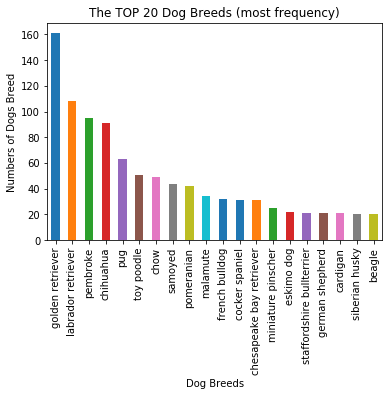

In [125]:
# Generate the bar chart to show each number of dog breed
dog_breed_an.pred_breed.value_counts()[0:20].plot('bar')
# Set title and x, y label
plt.title('The TOP 20 Dog Breeds (most frequency)')
plt.xlabel('Dog Breeds')
plt.ylabel('Numbers of Dogs Breed')

In [126]:
# Drop the records of which the retweet_count or favorite_count have null value
dog_breed_an.dropna(inplace=True)

In [127]:
# Convert the retweet_count and  favorite_count data type to int
dog_breed_an.retweet_count = dog_breed_an.retweet_count.astype(np.int64)
dog_breed_an.favorite_count = dog_breed_an.favorite_count.astype(np.int64)

### Top 20 dog breeds that have the most retweet numbers

Text(0,0.5,'Mean of the Retweet Numbers')

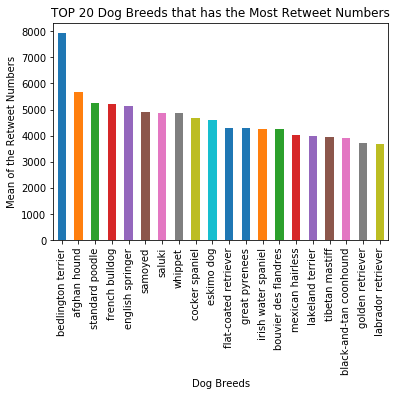

In [129]:
# Get top 20 dog breeds that have the most retweet numbers
retweet_breed_20 = dog_breed_an.groupby('pred_breed').retweet_count.mean().sort_values(ascending=False)[0:20]
# Generate the bar chart
retweet_breed_20.plot('bar')
# Set title and x, y label
plt.title('TOP 20 Dog Breeds that has the Most Retweet Numbers')
plt.xlabel('Dog Breeds')
plt.ylabel('Mean of the Retweet Numbers')

### Top 20 dog breeds that have the most favorite numbers

Text(0,0.5,'Mean of the Favorite Numbers')

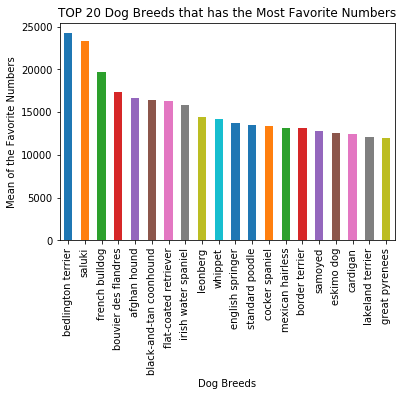

In [128]:
# Get top 20 dog breeds that have the most favorite numbers
favorite_breed_20 = dog_breed_an.groupby('pred_breed').favorite_count.mean().sort_values(ascending=False)[0:20]
# Generate the bar chart
favorite_breed_20.plot('bar')
# Set title and x, y label
plt.title('TOP 20 Dog Breeds that has the Most Favorite Numbers')
plt.xlabel('Dog Breeds')
plt.ylabel('Mean of the Favorite Numbers')

### Top 20 dog breeds that can be recognized easily by AI

Text(0,0.5,'Mean of Predition Scores (0-1)')

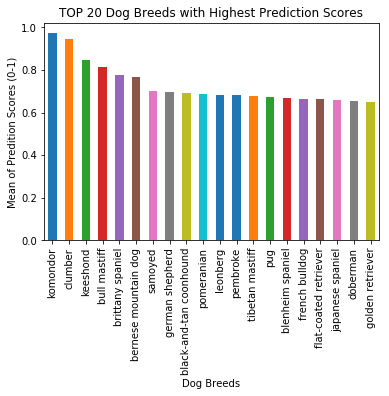

In [155]:
# Get the top 20 dog breeds that can be recognized easily by AI
pred_score_20 = dog_breed_an.groupby('pred_breed').pred_score.mean().sort_values(ascending=False)[0:20]
# Generate the bar chart
pred_score_20.plot('bar')
# Set title and x, y label
plt.title('TOP 20 Dog Breeds with Highest Prediction Scores')
plt.xlabel('Dog Breeds')
plt.ylabel('Mean of Predition Scores (0-1)')

### Dog Stages and Corresponding Number

Text(0,0.5,'Dog Number')

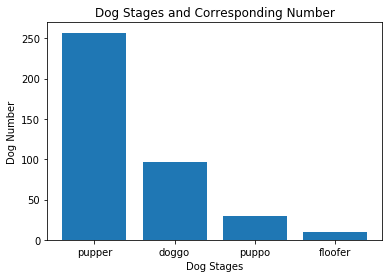

In [147]:
stage_names = tweet_dog_stage.dog_stage.value_counts().index.tolist()
stage_counts = tweet_dog_stage.dog_stage.value_counts().tolist()
plt.bar(x=stage_names, height=stage_counts)
plt.title('Dog Stages and Corresponding Number')
plt.xlabel('Dog Stages')
plt.ylabel('Dog Number')

In [148]:
# Create new dataframe to store the dog stage and retweet and favorite counts
dog_stage_an = twitter_archive_master[['tweet_id','retweet_count','favorite_count']]\
.merge(tweet_dog_stage, on='tweet_id', how='inner')

In [151]:
# Check info
dog_stage_an.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 9 to 2221
Data columns (total 4 columns):
tweet_id          362 non-null object
retweet_count     362 non-null float64
favorite_count    362 non-null float64
dog_stage         362 non-null object
dtypes: float64(2), object(2)
memory usage: 14.1+ KB


In [150]:
# Drop records of which the dog_stage is null
dog_stage_an.dropna(inplace=True)

In [152]:
# Convert the retweet_count and favorite_count to int type
dog_stage_an.retweet_count = dog_stage_an.retweet_count.astype(np.int64)
dog_stage_an.favorite_count = dog_stage_an.favorite_count.astype(np.int64)

### Dog Stages and Cooresponding Mean Retweet Numbers

Text(0,0.5,'Mean of the Retweet Counts')

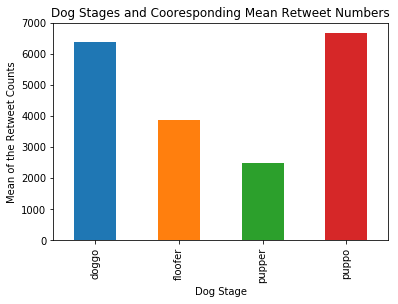

In [153]:
# Generate the bar chart to show the reteet number of each stage (where stage value is not none)
dog_stage_an.groupby('dog_stage')['retweet_count'].mean().plot('bar')
# Set title and x, y label
plt.title('Dog Stages and Cooresponding Mean Retweet Numbers')
plt.xlabel('Dog Stage')
plt.ylabel('Mean of the Retweet Counts')

### Dog Stages and Cooresponding Mean Favorite Numbers

Text(0,0.5,'Mean of the Favorite Number')

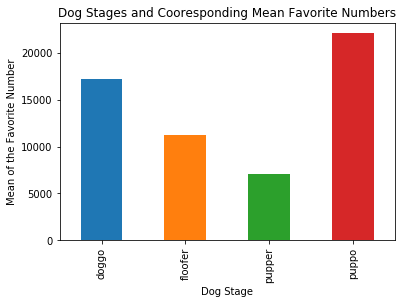

In [154]:
# Generate the bar chart to show the favorite number of each stage (where stage value is not none)
dog_stage_an.groupby('dog_stage')['favorite_count'].mean().plot('bar')
# Set title and x, y label
plt.title('Dog Stages and Cooresponding Mean Favorite Numbers')
plt.xlabel('Dog Stage')
plt.ylabel('Mean of the Favorite Number')

In [156]:
# Show all tweets' source
twitter_archive_master.source.value_counts()

Twitter for iPhone     2076
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Tweet Source and Mean Predition Precision

Text(0,0.5,'Mean Predition Precision')

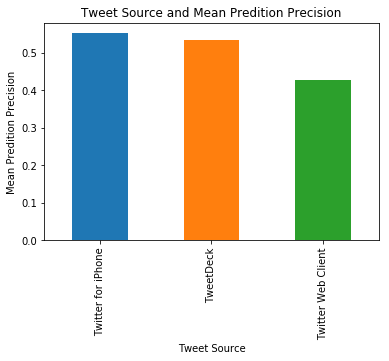

In [97]:
# Check relationship between tweet source and the predition precision
source_pred_rank = twitter_archive_master.groupby('source').pred_score.mean().sort_values(ascending=False)
# Generate bar chart 
source_pred_rank.plot('bar')
# Set title and x, y label
plt.title('Tweet Source and Mean Predition Precision')
plt.xlabel('Tweet Source')
plt.ylabel('Mean Predition Precision')